In [66]:
%matplotlib inline
import pymc3 as pm
import numpy as np
import pandas as pd
import scipy as sp
import seaborn as sns
import matplotlib.pyplot as plt
import arviz as az

%config InlineBackend.figure_formats = ['retina']
plt.style.use(['seaborn-colorblind', 'seaborn-darkgrid'])

RANDOM_SEED = 8927

### 10E1.
*If an event has probability 0.35, what are the log-odds of this event?*

In [6]:
sp.special.logit(0.35)

-0.6190392084062235

### 10E2.
*If an event has log-odds 3.2, what is the probability of this event?*

In [8]:
sp.special.expit(3.2) # in scipy, expit is the inverse of logit (aka logistic)

0.9608342772032357

### 10E3.
*Suppose that a coefficient in a logistic regression has value 1.7. What does this imply about the proportional change in odds of the outcome?*

If a unit-change in a predictor increases the log-odds (the scale on which logistic regressions parameters live) of the outcome by 1.7, then this implies that the odds are multiplied by:

In [10]:
np.exp(1.7)

5.4739473917272

This is a proportional increase of 5.5 in the odds of the outcome, i.e a 275% increase in the odds.

### 10E4.
*Why do Poisson regressions sometimes require the use of an offset? Provide an example?*

An offset is used in a Poisson regression when the outcome variable is observed on different periods of time. For instance, 75% of the observations are on a daily-basis, while 25% are on a montly basis. Here, the offset would be about 30 days, and would allow to model these two periods on the same scale.

### 10M1.
*As explained in the chapter, binomial data can be organized in aggregated and disaggregated forms, without any impact on inference. But the likelihood of the data does change when the data are converted between the two formats. Can you explain why?*

**Disaggregated version**: each row of the data is a trial, resulting in an observation of either 1 (success) or 0 (failure). The likelihood then is a Bernoulli distribution, which describes the probability p of getting a success for a given trial - like the probability of getting a non-broken Kinder Bueno when opening one.

**Aggregated version**: each row of the data is now a count of the successes we got for a given number n of trials - like the number of non-broken Kinder Buenos we got while opening (and eating) a large number of them. In other words, this is an aggregation of Bernoulli trials with probability. This generalization of the Bernoulli is called a Binomial distribution, which s entirely determined by the number n of trials and the probability of success p.

### 10M2.
*If a coefficient in a Poisson regression has value 1.7, what does this imply about the change in the outcome?*

Poisson regression parameters being on the log scale, we have to exponentiate them to interpret the change they imply on the outcome scale:

In [11]:
np.exp(1.7)

5.4739473917272

### 10M3.
*Explain why the logit link is appropriate for a binomial generalized linear model.*

If our goal is to model the p parameter of a binomial likelihood, then this parameter is on [0,1], while a linear model (a + bx) is on the real line [-inf, +inf]. The logit function - logit(p) = log(p/(1+p)) - allows to transcribe this proportion p on the real line. Note then that logit(0) = -inf, logit(0.5) = 0 and logit(1) = +inf. And logit(p) is not defined for p<0 or p>1.

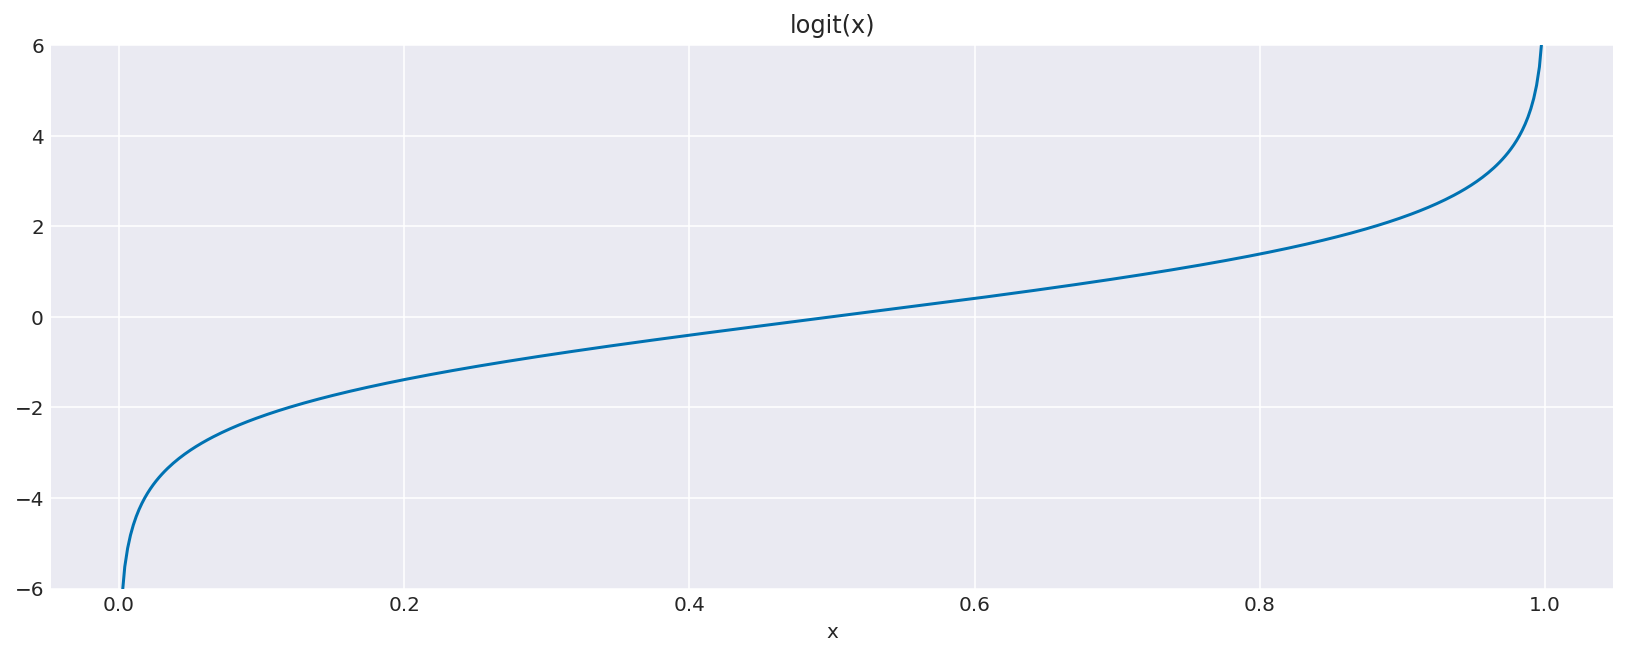

In [19]:
x = np.linspace(0, 1, 501)
y = sp.special.logit(x)
plt.figure(figsize=(14, 5))
plt.plot(x, y)
plt.ylim(-6, 6)
plt.xlabel('x')
plt.title('logit(x)');

### 10M4.
*Explain why the log link is appropriate for a Poisson generalized linear model.*

Our goal is to model the lambda parameter of the Poisson likelihood. This parameter is on [0, +inf], while a linear model (a + bx) is on the real line [-inf, +inf]. The log function allows to transcribe lambda on the real line.

### 10M5.
*What would it imply to use a logit link for the mean of a Poisson generalized linear model?*

The mean of a Poisson likelihood is, by definition, > 0, but logit is only defined on [0,1]. So, using a logit link for the mean of a Poisson GLM implies either that the true value of the mean cannot exceed 1, or that we can safely ignore the cases when it does.


*Can you think of a real research problem for which this would make sense?*

This could be useful if you were modeling an average number of occurrences that you know is positive but cannot exceed 1. In other words, you have scientific knowledge that allow you to put more constraints on the average count you are trying to infer.
In that case though, it could also be useful to fit and compare a model infering that average count with a Beta distribution, as it lives on [0,1].

### 10M6.
*State the constraints for which the binomial and Poisson distributions have maximum entropy. Are the constraints different at all for binomial and Poisson? Why or why not?*

The binomial distribution has maximum entropy when each trial must result in one of two events and the expected value (usually denoted p) is constant.

When a binomial has a very small expected probability p and a very large (or even unknown) number of trials n, then it converges to a Poisson distribution. Being a special case of the binomial, it has maximum entropy under exactly the same constraints.

### 10H1.
*Use map to construct a quadratic approximate posterior distribution for the chimpanzee model that includes a unique intercept for each actor, m10.4 (page 299).*

*Compare the quadratic approximation to the posterior distribution produced instead from MCMC.*

*Can you explain both the differences and the similarities between the approximate and the MCMC distributions?*

Related to R and map. See code 10.14 in chapter 10 notebook for model specification and MCMC estimation in PyMC3

### 10H2.
*Use WAIC to compare the chimpanzee model that includes a unique intercept for each actor, m10.4 (page 299), to the simpler models fit in the same section*

In [6]:
d = pd.read_csv('../Data/chimpanzees.csv', sep=";")
# we change "actor" to zero-index
d.actor = d.actor - 1
d.head()

,actor,recipient,condition,block,trial,prosoc_left,chose_prosoc,pulled_left
0,0,NaN,0,1,2,0,1,0
1,0,NaN,0,1,4,0,0,1
2,0,NaN,0,1,6,1,0,0
3,0,NaN,0,1,8,0,1,0
4,0,NaN,0,1,10,1,1,1


Intercept-only model (m10.1):

In [10]:
with pm.Model() as model_10_1:
    a = pm.Normal('a', 0, 10)
    p = pm.math.invlogit(a)    
    pulled_left = pm.Binomial('pulled_left', 1, p, observed=d.pulled_left)

    trace_10_1 = pm.sample(1000, tune=1000, cores=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:04<00:00, 944.54draws/s] 


Model predicting lever pulls using only prosoc_left (m10.2):

In [11]:
with pm.Model() as model_10_2:
    a = pm.Normal('a', 0, 10)
    bp = pm.Normal('bp', 0, 10)
    p = pm.math.invlogit(a + bp * d.prosoc_left)
    pulled_left = pm.Binomial('pulled_left', 1, p, observed=d.pulled_left)

    trace_10_2 = pm.sample(1000, tune=1000, cores=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [bp, a]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:08<00:00, 476.49draws/s]


Model including interaction between prosoc_left and condition (m10.3):

In [12]:
with pm.Model() as model_10_3:
    a = pm.Normal('a', 0, 10)
    bp = pm.Normal('bp', 0, 10)
    bpC = pm.Normal('bpC', 0, 10)
    p = pm.math.invlogit(a + bp * d.prosoc_left + bpC * d.condition * d.prosoc_left)
    pulled_left = pm.Binomial('pulled_left', 1, p, observed=d.pulled_left)

    trace_10_3 = pm.sample(1000, tune=1000, cores=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [bpC, bp, a]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:10<00:00, 394.76draws/s]


Model including interaction between prosoc_left and condition, and unique intercept for each actor (m10.4):

In [15]:
with pm.Model() as model_10_4:
    a = pm.Normal('alpha', 0, 10, shape=len(d.actor.unique()))
    bp = pm.Normal('bp', 0, 10)
    bpC = pm.Normal('bpC', 0, 10)
    p = pm.math.invlogit(a[d.actor.values] + bp * d.prosoc_left + bpC * d.condition * d.prosoc_left)
    pulled_left = pm.Binomial('pulled_left', 1, p, observed=d.pulled_left)

    trace_10_4 = pm.sample(1000, tune=1000, cores=2, nuts_kwargs={"target_accept": .95})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [bpC, bp, alpha]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:34<00:00, 103.25draws/s]


In [28]:
comp_df = pm.compare({model_10_1 : trace_10_1,
                      model_10_2 : trace_10_2,
                      model_10_3 : trace_10_3,
                      model_10_4 : trace_10_4})

comp_df.loc[:,'model'] = pd.Series(['m10.1', 'm10.2', 'm10.3', 'm10.4'])
comp_df = comp_df.set_index('model')
comp_df

/anaconda/envs/stat-rethink-pymc3/lib/python3.7/site-packages/pymc3/stats.py:168: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  return np.stack(logp)


,WAIC,pWAIC,dWAIC,weight,SE,dSE,var_warn
model,,,,,,,
m10.4,529.8,8.28,0,1,20,0,0
m10.2,680.64,2.07,150.84,0,9.38,19.26,0
m10.3,682.06,2.86,152.26,0,9.42,19.19,0
m10.1,687.97,1.01,158.17,0,7.25,19.99,0


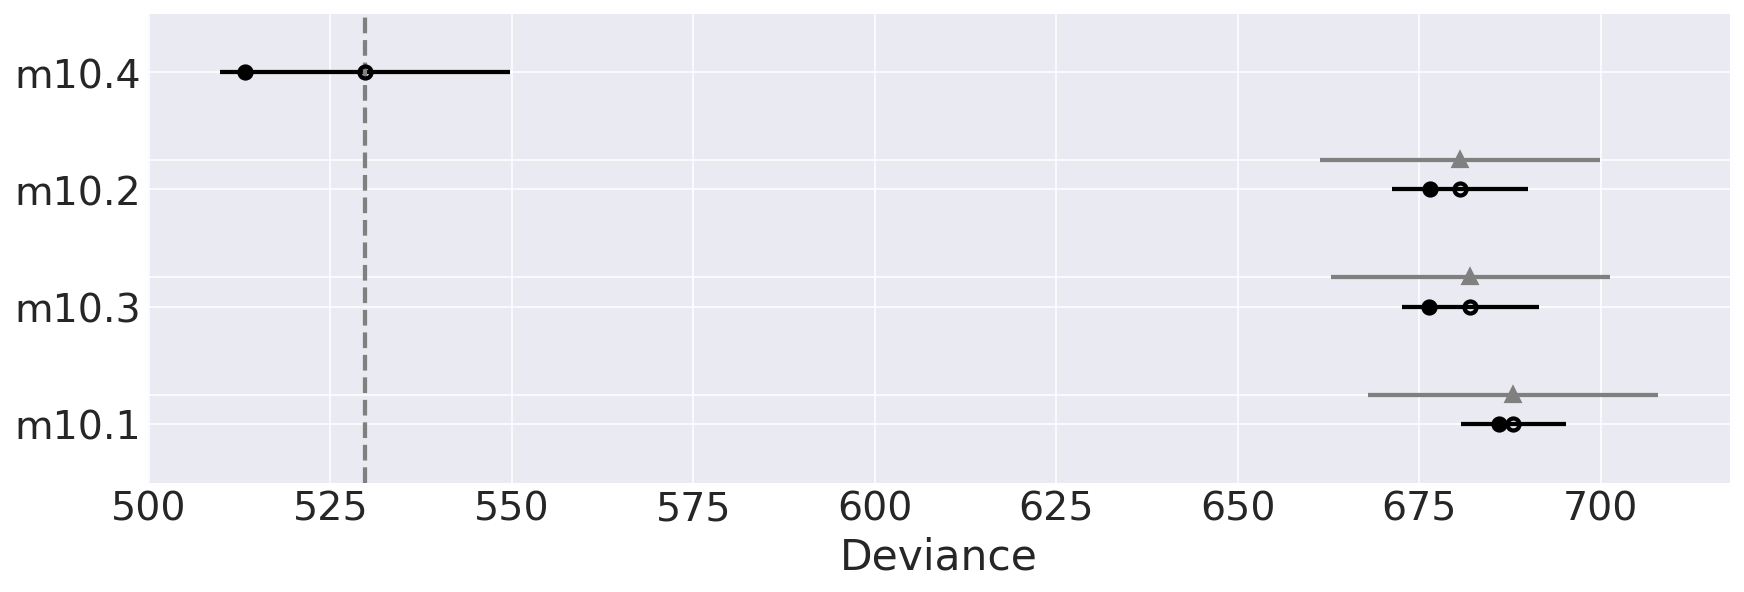

In [29]:
pm.compareplot(comp_df, figsize=(12, 4));

Based on information criteria, the most complex model looks clearly better than the simpler ones: it adds enough relevant information to fit the sample better while also lowering the expected overfit.

### 10H3.
*The data contained in eagles.csv are records of salmon pirating attempts by Bald Eagles in Washington State. While one eagle feeds, sometimes another will swoop in and try to steal the salmon from it. Call the feeding eagle the "victim" and the thief the "pirate". Use the available data to build a binomial GLM of successful pirating attempts.*

*Consider the following model:*

$y_{i} \sim Binomial(n_{i}, p_{i})$

$log\left(\frac{p_{i}}{1-p_{i}}\right) = \alpha + \beta_{P}P_{i} + \beta_{V}V_{i} + \beta_{A}A_{i}$

$\alpha \sim Normal(0, 10)$

$\beta_{P} \sim Normal(0, 5)$

$\beta_{V} \sim Normal(0, 5)$

$\beta_{A} \sim Normal(0, 5)$

where:

-  $y$ is the number of successful attempts
-  $n$ is the total number of attempts
-  $P$ is a dummy variable indicating whether or not the pirate had large body size
-  $V$ is a dummy variable indicating whether or not the victim had large body size
-  and finally $A$ is a dummy variable indicating whether or not the pirate was an adult

*Fit the model above to the eagles data and interpret the estimates* 

*[NB: the difference between map and map2stan is related to the rethinking package, not to PyMC - we directly fit using MCMC]*

In [28]:
d = pd.read_csv('../Data/eagles.csv', sep=";")

# Turn into dummies and select corresponding encoding
dummies = pd.get_dummies(d[["P", "A", "V"]]).iloc[:, ::2]
dummies.columns = ["P", "A", "V"]

d = d[["y", "n"]].join(dummies)
d

,y,n,P,A,V
0,17,24,1,1,1
1,29,29,1,1,0
2,17,27,1,0,1
3,20,20,1,0,0
4,1,12,0,1,1
5,15,16,0,1,0
6,0,28,0,0,1
7,1,4,0,0,0


In [32]:
with pm.Model() as eagles_model:
    # Priors
    a = pm.Normal('a', 0, 10)
    bp = pm.Normal('bp', 0, 5)
    bv = pm.Normal('bv', 0, 5)
    ba = pm.Normal('ba', 0, 5)
    
    #Linear model
    p = pm.math.invlogit(a + bp * d.P + bv * d.V + ba * d.A)
    
    #Likelihood
    pirated_salmons = pm.Binomial('pirated_salmons', d.n, p, observed=d.y)

    # Inference
    trace_eagles = pm.sample(1000, tune=1000, cores=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [ba, bv, bp, a]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:14<00:00, 274.59draws/s]


In [56]:
pm.summary(trace_eagles)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
a,0.663185,0.678126,0.020011,-0.557621,2.010899,1075.986841,0.999541
bp,4.702677,1.047638,0.032836,2.944114,6.927451,994.424003,0.999610
bv,-5.112974,1.115775,0.037280,-7.431304,-3.204546,930.822653,0.999691
ba,1.126416,0.548107,0.014847,-0.002195,2.156810,1226.022764,1.000999


/anaconda/envs/stat-rethink-pymc3/lib/python3.7/site-packages/arviz/data/io_pymc3.py:56: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  chain_likelihoods.append(np.stack(log_like))


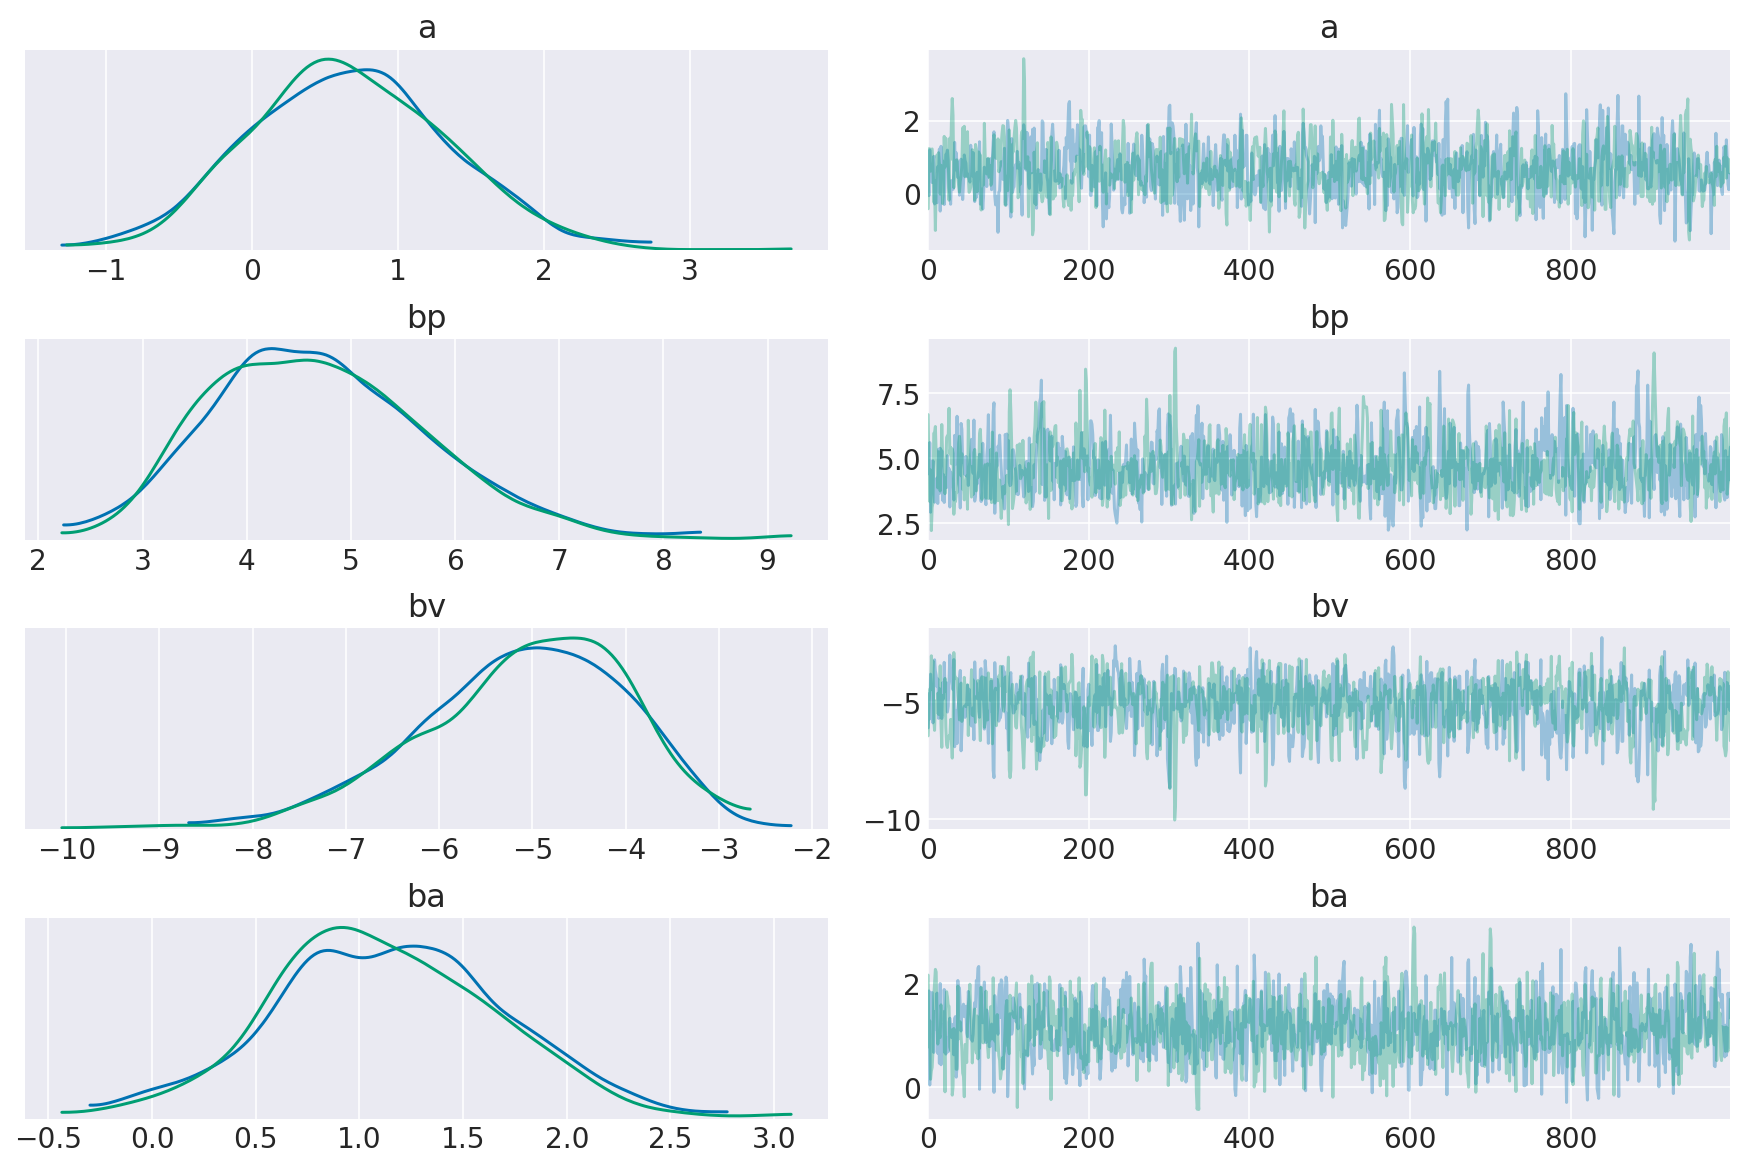

In [95]:
# lines = (('a', {'a_dim_0': 0}, [-1, 1]), ('bp',{'bp_dim_0': 0}, [-1]))
# lines=pm.summary(trace_eagles)['mean'].to_dict()
az.plot_trace(trace_eagles, lines=lines);

In [67]:
with eagles_model:
    ppc = pm.sample_posterior_predictive(trace_eagles, random_seed=RANDOM_SEED)
ppc

100%|██████████| 2000/2000 [00:05<00:00, 363.08it/s]


{'pirated_salmon': array([[18, 29, 13, ..., 16,  0,  3],
        [20, 29,  7, ..., 11,  0,  1],
        [16, 29, 21, ..., 12,  0,  2],
        ...,
        [20, 29, 10, ..., 13,  1,  4],
        [18, 29, 13, ..., 12,  0,  3],
        [20, 29, 19, ..., 15,  1,  2]])}

In [71]:
ppc['pirated_salmons'][:2]

array([[18, 29, 13, 20,  0, 16,  0,  3],
       [20, 29,  7, 20,  1, 11,  0,  1]])

In [30]:
import sys, IPython, scipy, matplotlib, platform
print("This notebook was createad on a computer %s running %s and using:\nPython %s\nIPython %s\nPyMC3 %s\nNumPy %s\nPandas %s\nSciPy %s\nMatplotlib %s\n" % (platform.machine(), ' '.join(platform.linux_distribution()[:2]), sys.version[:5], IPython.__version__, pm.__version__, np.__version__, pd.__version__, scipy.__version__, matplotlib.__version__))

This notebook was createad on a computer x86_64 running   and using:
Python 3.7.3
IPython 7.5.0
PyMC3 3.6
NumPy 1.16.3
Pandas 0.24.2
SciPy 1.2.1
Matplotlib 3.0.3



/anaconda/envs/stat-rethink-pymc3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: dist() and linux_distribution() functions are deprecated in Python 3.5
  
